In [6]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
import qiskit

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


In [7]:
def phase_oracle(qc, n, indices_to_mark):
    
    oracle_matrix = np.identity(2**n)
    for i in indices_to_mark:
        oracle_matrix[i,i] = -1
        
    qc.unitary(qiskit.quantum_info.Operator(oracle_matrix), range(n))

In [8]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(q[0:nqubits-1],q[nqubits-1], None, 'noancilla')  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

In [31]:
n = 4
M = [13]
t = 2^n

q = QuantumRegister(n, 'q')
k = QuantumRegister(n, 'k')
c = ClassicalRegister(n, 'c')

qc = QuantumCircuit(q, k, c)


qc.h(q)

for i in range(math.ceil(np.sqrt(t/len(M)))):
    phase_oracle(qc, n, M)
    qc.append(diffuser(n), list(range(n)))
    
qc.measure(q,c)

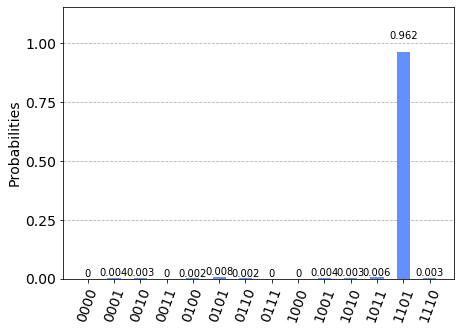

In [32]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)